# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_google_genai

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")

We'll use [LangSmith](https://docs.langchain.com/langsmith/home) for [tracing](https://docs.langchain.com/langsmith/observability-concepts).

We'll log to a project, `langchain-academy`. I will use `python-dotenv` to do this with `.env` file. 

In [3]:
from dotenv import load_dotenv

load_dotenv()

True

## Messages as state

First, let's define some messages.

In [4]:
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage("So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="pytholic"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: pytholic

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")
llm.invoke(messages)

AIMessage(content='That\'s a fantastic area to research! Whales (and dolphins and porpoises, which are all cetaceans) are incredible, but the ocean is home to many other fascinating mammals.\n\nHere are the main groups you should definitely learn about, beyond cetaceans:\n\n1.  **Pinnipeds (Seals, Sea Lions, and Walruses)**\n    These are "fin-footed" mammals that spend significant time both in water and on land (or ice). They are carnivores, primarily eating fish and invertebrates.\n\n    *   **True Seals (Phocidae):**\n        *   **Characteristics:** No external ear flaps, cannot rotate their hind flippers forward (so they "scoot" on their bellies on land), generally smaller front flippers. They are more streamlined in water.\n        *   **Examples:** Harbor seals, Harp seals, Elephant seals, Monk seals, Ringed seals, Weddell seals.\n        *   **Fun Fact:** Elephant seals are the largest seals and can dive to incredible depths for extended periods.\n\n    *   **Eared Seals (Otari

We can run our chat model in a simple graph with `MessagesState`.

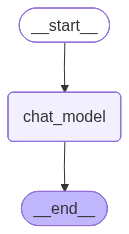

In [6]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: pytholic

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Excellent! Whales (cetaceans: baleen and toothed whales, dolphins, porpoises) are a fantastic starting point, but there's a whole world of other incredible ocean mammals out there.

Here are the main groups you should definitely learn about:

1.  **Pinnipeds (Seals, Sea Lions, and Walruses)**
    *   **What they are:** "Fin-footed" mammals that spend most of their lives in the water but come ashore (or onto ice) to breed, rest, and molt. They are carnivorous, eating fish, squid, and crustaceans.
    *   **Key Differences:**
        *   **True Seals (Phocidae):** No external ear flaps. They can't rotate their h

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

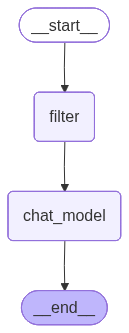

In [8]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="pytholic", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="pytholic", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: pytholic

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's a fantastic field to research! While whales (which include both baleen whales like humpbacks and blue whales, and toothed whales like sperm whales) are fascinating, there's a whole world of other incredible ocean mammals out there.

Here are some major groups and examples you should definitely learn about:

1.  **Pinnipeds (Seals, Sea Lions, and Walruses):**
    These are semi-aquatic marine mammals, meaning they spend significant time both in the water and on land (or ice). They all have flippers!

    *   **True Seals (Phocidae):**
        *   **Characteristics:** No external ear flaps, can't rotate t

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

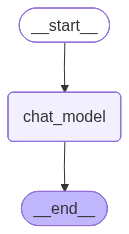

In [10]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [11]:
messages.append(output['messages'][-1])
messages.append(HumanMessage("Tell me more about Narwhals!", name="pytholic"))

In [12]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: pytholic

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: pytholic

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's a fantastic field to research! While whales (which include both baleen whales like humpbacks and blue whales, and toothed whales like sperm whales) are fascinating, there's a whole world of other incredible ocean mammals out there.

Here are some major groups and examples you should definitely learn about:

1.  **Pinnipeds (Seals, Sea Lions, and Walruses):**
    These are semi-aquatic marine mammals, meaning t

In [13]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: pytholic

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: pytholic

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's a fantastic field to research! While whales (which include both baleen whales like humpbacks and blue whales, and toothed whales like sperm whales) are fascinating, there's a whole world of other incredible ocean mammals out there.

Here are some major groups and examples you should definitely learn about:

1.  **Pinnipeds (Seals, Sea Lions, and Walruses):**
    These are semi-aquatic marine mammals, meaning t

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/a0e5e75c-fd8f-453a-be94-9ff9f2aae7ef/r

## Trim messages

Another approach is to [trim messages](https://docs.langchain.com/oss/python/langgraph/add-memory#trim-messages), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

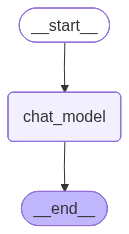

In [14]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatGoogleGenerativeAI(model="gemini-2.5-flash"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
messages.append(output['messages'][-1])
messages.append(HumanMessage("Tell me where Orcas live!", name="pytholic"))

In [20]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatGoogleGenerativeAI(model="gemini-2.5-flash"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='pytholic', id='e2933438-21e4-4193-87e9-6372799274d0')]

In [18]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/0a50ce07-dcde-4efb-95f9-1a898cd6b707/r

In [21]:
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

# Create test messages
test_messages = [
    AIMessage(
        content="In summary, narwhals are truly magnificent and mysterious creatures, perfectly adapted to their extreme Arctic environment. Their unique tusk, deep-diving abilities, and social behaviors make them a constant source of wonder and scientific study, especially as their world faces rapid changes due to climate change.",
        name="Bot"
    ),
    HumanMessage(
        content="Tell me where Orcas live!",
        name="pytholic"
    )
]

# Try to get token count (method varies by LangChain version)
try:
    # Newer versions
    token_count = model.get_num_tokens_from_messages(test_messages)
    print(f"Actual token count: {token_count}")
except AttributeError:
    # Alternative: use the internal token counter
    from langchain_core.messages import get_buffer_string
    text = get_buffer_string(test_messages)
    print(f"Text length: {len(text.split())}")

Actual token count: 68
